In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
from datetime import datetime

usertypes_infos = {
    'unknown': 0,
    'customers': 0,
    'subscribers': 0,
    'students': 0,
    'others': 0
}
    
meaning_pass = {
    'Indego30': 'subscribers',
    'Indego365': 'subscribers',
    'Walk-up': 'others',
    'Day Pass': 'customers',
    'IndegoFlex': 'subscribers',
    'Walk Up': 'customers',
    'Local365': 'subscribers',
    'Local30': 'subscribers',
    'Local31': 'subscribers',
    'Local365+Guest Pass': 'subscribers',
    'Republic Rider': 'others',
    'Student Membership': 'students',
    'U.T. Student Membership': 'students',
    '3-Day Weekender': 'customers',
    'Explorer': 'customers',
    'Pay-as-you-ride': 'customers',
    'Single Trip (Pay-as-you-ride)': 'customers',
    'customers': 'customers',
    'subscribers': 'subscribers',
    'casual': 'customers',
    'member': 'subscribers',
    'Casual': 'customers',
    'Member': 'subscribers',
    'unknown': 'unknown'
}

genders_infos = {
    'unknown': 0,
    'men': 0,
    'women': 0,
}

meaning_gender = {
    '0': 'unknown',
    '1': 'men',
    '2': 'women',
    'Male': 'men',
    'Female': 'women',
    'Unknown': 'unknown'
}

In [3]:
def prepare_plot(axs, fig, frequency, number, city, linear=False):
    '''
    Function to prepare the plot for the data
    
    Input:
        - axs: list
        - fig: Figure
        - frequency: dict
        - number: int
        - city: str
        - linear: bool
        
    Output:
        - None
    '''
    if linear:
        prepare_plot_linear(axs, fig, frequency, number, city)
    else:
        prepare_plot_log(axs, fig, frequency, number, city)

def prepare_plot_log(axs, fig, frequency, number, city):
    '''
    function to prepare the plot for the log scale
    
    Input:
        - axs: list
        - fig: Figure
        - frequency: dict
        - number: int
        - city: str
    
    Output:
        - None
    '''
    x = number // 3
    y = number % 3
    
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    
    bin_edges = np.logspace(np.log10(cluster_names[0]), np.log10(cluster_names[-1]), num=len(cluster_names)+1)
    bar_width = np.diff(bin_edges)
    
    axs[x, y].bar(bin_edges[:-1], cluster_frequencies, width=bar_width, align='center')
    axs[x, y].set_xscale('log')
    axs[x, y].set_yscale('log')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    title = 'Frequency of Trip Duration for ' + city
    fig.suptitle(title)

def prepare_plot_linear(axs, fig, frequency, number, city):
    '''
    Function to prepare the plot for the linear scale
    
    Input:
        - axs: list
        - fig: Figure
        - frequency: dict
        - number: int
        - city: str
    
    Output:
        - None
    '''
    x = number // 3
    y = number % 3
    
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    
    axs[x, y].bar(cluster_names, cluster_frequencies, align='center')
    
    for index in range(len(cluster_names)):
        axs[x, y].text(index, cluster_frequencies[index], str(round(cluster_frequencies[index], 5)), ha='center')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    title = 'Frequency of Trip Duration for ' + city
    fig.suptitle(title)

In [4]:
def get_time(df, number_to_analyse, full_path):
    '''
    function to get the duration of the trip for each file
    If the file has the duration column (in seconds or in minutes) we can directly get the duration
    Otherwise, we have to calculate the duration by subtracting the start time from the end time
    The function takes in consideration the format of the date for each file
    
    Input:
        - df: DataFrame
        - number_to_analyse: int
        - full_path: str
    Output:
        - durations: list
    '''
    durations = list()
    if 'trip_duration_seconds' in df or 'trip_duration_minutes' in df:
        
        if 'trip_duration_seconds' in df:
            duration = df['trip_duration_seconds']
            durations = [time for time in duration]
        else:
            duration = df['trip_duration_minutes']
            durations = [time * 60 for time in duration]
    else:
        
        start = df['start_time']
        end = df['stop_time']
        
        if 'NYC' in full_path:
            if full_path[14:20] >= '202102':
                format = "%Y-%m-%d %H:%M:%S"
            else:
                format = "%Y-%m-%d %H:%M:%S.%f"
        else:
            format = "%Y-%m-%d %H:%M:%S"
        
        for index in range(len(end)):
            if 'Philly' in full_path or ('Chicago' in full_path and (full_path[17:23] < '202004' or '2020Q1' in full_path)):
                month = datetime.strptime(end[index], '%Y-%m-%d %H:%M:%S').month
                if number_to_analyse == month:
                    time = datetime.strptime(end[index], format) - datetime.strptime(start[index], format)
                    durations.append(time.total_seconds())
            time = datetime.strptime(end[index], format) - datetime.strptime(start[index], format)
            durations.append(time.total_seconds())
        
    durations.sort()
    return durations

def get_cluster(num):
    '''
    function to determine the cluster for each number
    This function is used for the linear plot of the data to cluster the durations into 5 clusters
    
    Input:
        - num: int
        
    Output:
        - str
    '''
    if type(num) == str:
        num = int(float(num.replace(',', '')))
    if num < 100:
        return "<100"
    elif num < 1000:
        return "<1000"
    elif num < 10000:
        return "<10000"
    elif num < 100000:
        return "<100000"
    else:
        return ">100000"

def get_duration_info(df, number, full_path, linear=False):
    '''
    function to get the duration information for each file, cluster them and plot the frequency of each cluster
    This function calls the get_time function to get the duration of the trip for each file and then acts accordingly to the linear flag:
    if it is True, it clusters the durations into 5 clusters, otherwise it plots the frequency of each duration using a log scale
    
    Input:
        - df: DataFrame
        - number: int
        - full_path: str
        - linear: bool
        
    Output:
        - frequency: dict
    '''
    durations = get_time(df, number, full_path)

    if linear:
        # Group numbers into clusters
        clusters = [get_cluster(num) for num in durations]

        # Calculate frequency of each cluster
        frequency = Counter(clusters)
    else:
        frequency = Counter(durations)

    # Extract cluster names and their frequencies
    if linear:
        total = sum(frequency.values())
        for key in frequency:
            frequency[key] /= total
    
    return frequency

def data_for_month(data_dir, city, year_flag=False, linear=False):
    '''
    Function to plot the trip duration frequency for each month. The function takes two flags: year_flag and linear.
    If year_flag is True, the function plots the data for each year, otherwise it plots the data for each month.
    If linear is True, the function clusters the data into 5 clusters, otherwise it plots the data using a log scale.
    
    Input:
        - data_dir: str
        - year_flag: bool
        - linear: bool
        
    Output:
        - frequency_dict: dict
    '''

    data_files = os.listdir(data_dir)
    month = 0

    if not year_flag:
        if linear:
            fig, ax = plt.subplots(4, 3)
        else:
            fig, ax = plt.subplots(4, 3, sharex=True)
    if linear:
        frequency_dict = {
            '<100': 0,
            '<1000': 0,
            '<10000': 0,
            '<100000': 0,
            '>100000': 0
        }

    for file in data_files:
        # read data from each file into a DataFrame
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)
        
        if city == 'Philly' or (city == 'Chicago' and file_path[18:24] < '202004') or  (city == 'Chicago' and '2020Q1' in file_path):
            month = (int(file[5:6]) - 1) * 3
            for _ in range(3):
                frequency = get_duration_info(df, month, file_path, linear)
                if not year_flag:
                    prepare_plot(ax, fig, frequency, month, city, linear)
                month += 1
        else:
            month = int(file[4:6]) - 1
            frequency = get_duration_info(df, month, file_path, linear)
            if not year_flag:
                prepare_plot(ax, fig, frequency, month, city, linear)
        if linear:
            for key in frequency:
                frequency_dict[key] += frequency[key]

    if not year_flag:
        plt.show()
    
    if linear:
        return frequency_dict
    return frequency

def data_for_year(data_dir, city, linear=False):
    '''
    function to plot the data for each year
    '''

    fig, ax = plt.subplots(2, 3)
    if linear:
        yearly_frequency = {
            '<100': 0,
            '<1000': 0,
            '<10000': 0,
            '<100000': 0,
            '>100000': 0
        }
    else:
        yearly_frequency = dict()
    
    for year in os.listdir(data_dir):
        year_path = os.path.join(data_dir, year)
        frequency = data_for_month(year_path, city, year_flag=True, linear=linear)
        for key in frequency:
            if key in yearly_frequency:
                yearly_frequency[key] += frequency[key]
            else:
                yearly_frequency[key] = frequency[key]
        if linear:
            total = sum(yearly_frequency.values())
            for key in yearly_frequency:
                yearly_frequency[key] /= total
        
        year = int(year) - 2018
        prepare_plot(ax, fig, yearly_frequency, year, city, linear=linear)
        frequency.clear()
    
    # Show plot
    plt.show()

In [5]:
def remove_zeros(data):
    to_remove = list()
    for key in data:
        if data[key] == 0:
            to_remove.append(key)
    for key in to_remove:
        data.pop(key)

def data_for_gender(data_dir, city):
    '''
    Function to plot the distribution of the trip between men and women
    
    Input:
        - data_dir: str
        
    Output:
        - None
    '''
    data_files = os.listdir(data_dir)

    for year in data_files:
        # read data from each file into a DataFrame
        year_path = os.path.join(data_dir, year)
        for file in os.listdir(year_path):
            
            file_path = os.path.join(year_path, file)
            
            df = pd.read_csv(file_path, dtype='object')
            count = df['gender'].value_counts()
            # plot the percentage of each data
            for key in meaning_gender:
                if key in count:
                    genders_infos[meaning_gender[key]] += count.loc[key]
    
    if genders_infos['men'] != 0 or genders_infos['women'] != 0:
        remove_zeros(genders_infos)
        fig, ax = plt.subplots()
        plt.title(city)
        plt.pie(genders_infos.values(), labels=genders_infos.keys(),  autopct='%1.1f%%')
        plt.show()
    else:
        print('Gender data not available in this city:', city)

def data_for_usertype(data_dir, city):
    
    data_files = os.listdir(data_dir)

    for year in data_files:
        # read data from each file into a DataFrame
        year_path = os.path.join(data_dir, year)
        
        for file in os.listdir(year_path):
            file_path = os.path.join(year_path, file)
        
            df = pd.read_csv(file_path, dtype='object')
            count = df['usertype'].value_counts()
            for key in meaning_pass:
                if key in count:
                    usertypes_infos[meaning_pass[key]] += count.loc[key]
    
    remove_zeros(usertypes_infos)
    
    fig, ax = plt.subplots()
    plt.title(city)
    plt.pie(usertypes_infos.values(), labels=usertypes_infos.keys(),  autopct='%1.1f%%')
    plt.show()

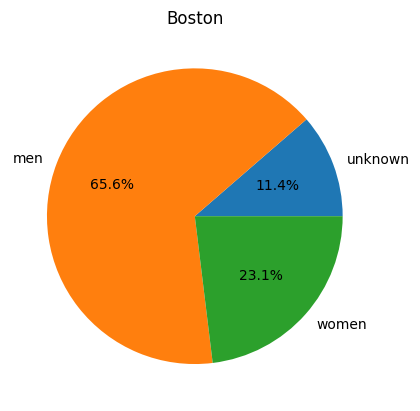

In [6]:
bikes = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/bikes'
city = 'Boston'
year = '2020'
missing_data = list()

city_file = os.path.join(bikes, city)
final_file = os.path.join(bikes, city, year)

data_for_gender(city_file, city)

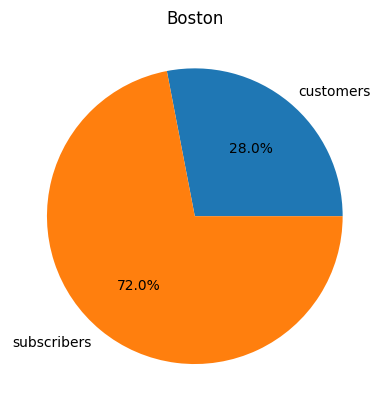

In [7]:
data_for_usertype(city_file, city)

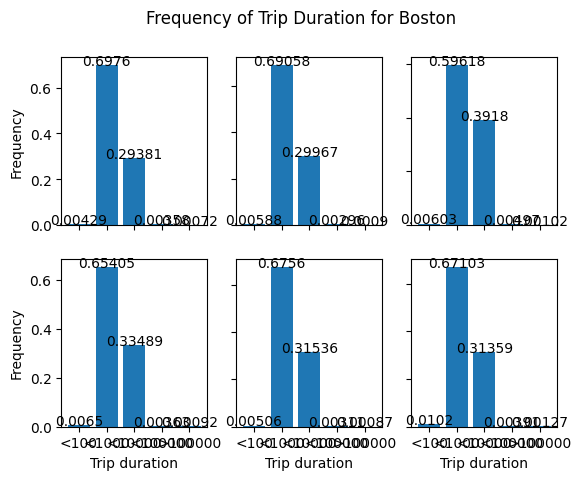

In [8]:
data_for_year(city_file, city, linear=True)

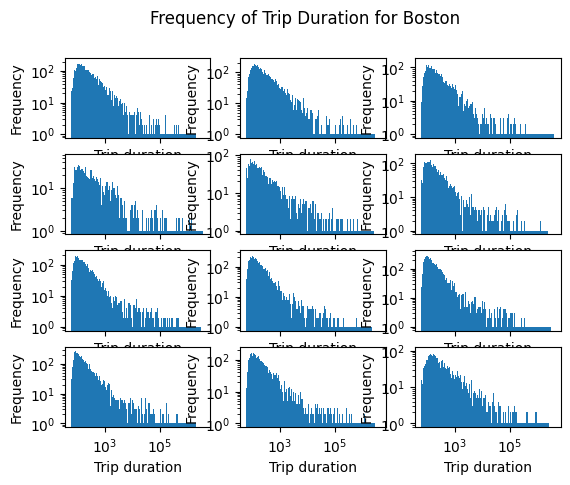

Counter({363: 101,
         354: 99,
         408: 99,
         305: 97,
         359: 97,
         400: 97,
         319: 96,
         322: 95,
         375: 94,
         377: 93,
         393: 93,
         339: 92,
         404: 91,
         315: 90,
         372: 90,
         405: 90,
         343: 89,
         399: 89,
         401: 89,
         428: 89,
         448: 89,
         455: 89,
         296: 88,
         357: 87,
         384: 87,
         398: 87,
         268: 86,
         356: 86,
         394: 86,
         438: 86,
         543: 86,
         325: 85,
         338: 85,
         346: 85,
         355: 85,
         423: 85,
         436: 85,
         441: 85,
         484: 85,
         289: 84,
         352: 84,
         397: 84,
         412: 84,
         418: 84,
         299: 83,
         331: 83,
         344: 83,
         350: 83,
         353: 83,
         361: 83,
         385: 83,
         390: 83,
         440: 83,
         313: 82,
         318: 82,
         

In [9]:
data_for_month(final_file, city)